In [1]:
import cvxpy as cp
import numpy as np
import cmath
from hsbalance import tools, model
from hsbalance.CI_matrix import Alpha
import matplotlib.pyplot as plt

# Introduction

This notebook is aimed to give a quick presentation for `hsbalance` package.
`hsbalance` is Python based package that is meant to find the optimized solution of rotor balancing problem

# A. Independent Systems
# # Creating Model
<b>for independent systems where number of balancing planes are equal to the number of measuring points we do not need optimization process as number of equations are equal to the number of unkowns

1. Enter the intial vibration column vector `A`:
- each row represents the vibration at certain measuring plane.
- vibration is to be represented in the form ('amplitude' @ 'phase(degrees)')
- Enter solw roll vibration column `A0`

In [2]:
A_math = [['170@112'],
     ['53@78']]

A0_math = [['0@0'],
      ['0@0']]

2. Enter trial mass effect matrix `B`
B = [['B00', 'B01']
     ['B10', 'B11']]
where:
- B00: vibration at measuring point 1 when trial mass at balancing plane 1
- B01: vibration at measuring point 1 when trial mass at balancing plane 2
- B00: vibration at measuring point 2 when trial mass at balancing plane 1
- B00: vibration at measuring point 2 when trial mass at balancing plane 2

As a generatl rule in this notebook columns will be for balancing planes and rows are for measuring points

In [3]:
B_math = [['235@94', '189@115'],
     ['58@68', '77@104']]

3. Enter the trial mass amounts in row vector `U`:

In [4]:
U_math = ['1.15@0', '1.15@0']

4. Transform matrices to cartesian (complex number) form:

In [5]:
A = tools.convert_matrix_to_cart(A_math)
A0 = tools.convert_matrix_to_cart(A0_math)
B = tools.convert_matrix_to_cart(B_math)
U = tools.convert_matrix_to_cart(U_math)
print('A=\n{}\n\nA0=\n{}\n\nB=\n{}\n\nU = {}'.format(A, A0, B, U))

A=
[[-63.68312088+157.62125528j]
 [ 11.01931961 +51.84182284j]]

A0=
[[0.+0.j]
 [0.+0.j]]

B=
[[-16.39277133+234.42755181j -79.87485147+171.29217175j]
 [ 21.72718242 +53.77666356j -18.62798596 +74.71277092j]]

U = [1.15+0.j 1.15+0.j]


As in this example, this is an independent system where number of measuring points (M) are equal to the number of balancing planes (N).
we, thus, except an exact solution for balancing weights `W` that can be calculated first by find the Influence Coeffecients matrix `ALPHA`:
\begin{align}
  \tag {1}
  \alpha = \frac{(B - (A - A_{0}))}{U} \label{eq:test1}
\end{align}
\begin{align}
    \tag {2}
    W = \alpha^{-1}(A - A_{0})
\end{align}

In [6]:
Alpha_CI = (B - (A - A0))/U
W = np.linalg.inv(Alpha_CI) @ (A - A0)

In [7]:
Alpha_CI

array([[ 41.12204309+66.78808394j, -14.07976573+11.88775346j],
       [  9.31118505 +1.6824702j , -25.78026572+19.88778094j]])

In [8]:
W

array([[1.05263968+1.6483921j ],
       [0.55431148-0.91924106j]])

Transform back to mathmatical expression form

In [9]:
ALPHA_math = tools.convert_matrix_to_math(Alpha_CI)
W_math = tools.convert_matrix_to_math(W)
print('ALPHA=\n{}\n\nW=\n{}'.format(ALPHA_math, W_math)) 

ALPHA=
[['78.4@58.4' '18.4@139.8']
 ['9.5@10.2' '32.6@142.4']]

W=
[['2.0@57.4']
 ['1.1@301.1']]


>This means we need to put 2 grams at angel 57.4 degrees on balancing plane 1, and 1.1 grams at 301.1 degrees on plane 2.

- Lets Try out the same independent system problem using our optimization modelling code:  
- first we will create a model of the system parameters:  
- we will be using least squares model to solve the problem using optimization technique to minimize the squares of errors:

In [10]:
alpha = Alpha()  # create an instance of alpha class
alpha.add(A=A, B=B, A0=A0, U=U)  # calculate alpha from parameters

In [11]:
tools.convert_matrix_to_math(alpha.value)

array([['78.4@58.4', '18.4@139.8'],
       ['9.5@10.2', '32.6@142.4']], dtype='<U10')

In [12]:
my_model = model.LeastSquares(A-A0, ALPHA=alpha.value)

In [13]:
W = my_model.solve()

In [14]:
tools.convert_matrix_to_math(W)

array([['2.0@237.4'],
       ['1.1@121.1']], dtype='<U9')

Which is exactly as the exact solution

# A. Dependent Systems
## Introduction
In dependent systems, number of measuring points are less than the number of balancing planes.  
This will lead to a problem with infinite number of solutions as the number of unknowns are less than the number of equations.  
We can use optimization technique here effectively to reduce the error and we can apply constraints to our model.

We will be example.[[1]](#1) which presents a 1150 MW nuclear power turbine-generator
balancing problem. The system consists of 11 measuring points and 5 balancing planes. (independent system)  
In practical plane #4 was not accessible.  


<a id="1">[1]</a> 
Gunter, E J, Allaire, P E, and Foiles, W C. Balancing a 1150 MW turbine-generator. United Kingdom: N. p., 2000. Web.


## Parameters

In [15]:
ALPHA_math=[
                            ['9.8@117', '17@124', '7.2@114', '38.5@77'],
                            ['2.7@43', '14.3@317', '4.5@213', '14.3@270'],
                            ['12.5@323', '25@261', '15.2@158', '30@238'],
                            ['22.4@92', '32.6@45', '23.3@315', '27.8@210'], 
                            ['26@94', '40.3@9', '25@330', '34@213'],
                            ['40.3@355', '43@144', '29.6@61', '65.4@322'],
                            ['20.6@339', '32.3@152', '36.7@41', '61.8@322'],
                            ['12.6@226', '37.6@52', '18.8@153', '26@176'],
                            ['13.4@209', '26.9@76', '47.5@98', '71.7@312'],
                            ['13.4@154', '22.4@307', '52@299', '102@165'],
                            ['5.4@24', '7.2@199', '22.4@2', '27.8@99']]

A_math=[
                            ['55@259'], 
                            ['45@118'],
                            ['124@21'],
                            ['138@349'],
                            ['107@349'],
                            ['90@280'],
                            ['58@354'],
                            ['108@201'],
                            ['88@190'],
                            ['56@48'],
                            ['73@158']]

Convert to complex numbers (cartesian) form

In [16]:
A = tools.convert_matrix_to_cart(A_math)
ALPHA = tools.convert_matrix_to_cart(ALPHA_math)
# A, ALPHA

Adding ALPHA

In [17]:
alpha = Alpha()
alpha.add(direct_matrix=ALPHA)

In [18]:
alpha.check()

Not a square matrix --> no exact solution

No ill-conditioned planes --> OK


## Solving with Least squares:

In [19]:
model_LeastSquares = model.LeastSquares(A, ALPHA, name='Least_squares') # Instantiate least square model

In [20]:
W_LeastSquares = model_LeastSquares.solve() #solve

In [21]:
tools.convert_matrix_to_math(W_LeastSquares)

array([['3.8@90.7'],
       ['2.2@358.4'],
       ['1.7@299.3'],
       ['1.5@292.5']], dtype='<U9')

In [22]:
residuals_LeastSquares = model_LeastSquares.expected_residual_vibration()
tools.convert_matrix_to_math(residuals_LeastSquares) # Expected residule vibrations

array([['19.9@266.8'],
       ['37.6@147.4'],
       ['106.6@35.2'],
       ['60.0@5.1'],
       ['63.1@328.9'],
       ['39.6@125.6'],
       ['58.5@355.2'],
       ['67.0@112.2'],
       ['51.9@242.4'],
       ['33.5@132.4'],
       ['46.9@141.6']], dtype='<U10')

Root mean square error:

In [23]:
rmse_LeastSquares = model_LeastSquares.rmse()
rmse_LeastSquares

53.1472

### Discussion
Least square has iterated over to get the minium squres of erros (hence, the least `rmse`)  
Doing so, it does it blindly so we can see that it add huge amount of weight at plane 1 (3.8 kg!), meanwhile vibration on bearing #3 is expected to be 106 $\mu$ which is probably an alarm value!!

## Solving with MinMax:

In [24]:
model_MinMax = model.Min_max(A, ALPHA, name='MinMax') # Instantiate MinMax model

In [25]:
W_MinMax = model_MinMax.solve() #solve

In [26]:
tools.convert_matrix_to_math(W_MinMax)

array([['4.4@88.6'],
       ['2.9@352.5'],
       ['1.5@322.5'],
       ['1.9@305.5']], dtype='<U9')

In [27]:
residuals_MinMax = model_MinMax.expected_residual_vibration()
tools.convert_matrix_to_math(residuals_MinMax) # Expected residule vibrations

array([['10.3@95.7'],
       ['31.9@177.5'],
       ['69.9@30.1'],
       ['69.5@13.7'],
       ['69.9@330.6'],
       ['69.9@105.2'],
       ['69.9@14.9'],
       ['69.9@108.8'],
       ['69.9@249.7'],
       ['52.4@136.6'],
       ['69.9@116.7']], dtype='<U10')

Root mean square error:

In [28]:
rmse_MinMax = model_MinMax.rmse()
rmse_MinMax

59.4236

### Discussion
`MinMax` is a great optimization tool that tends to, instead of unbiased `Least Squares`, level up the residuals to minimize the maximum. here we see that we have a great improvement in the residual vibrations (max 70$\mu\$).  
The downside is putting more and more wieghts in the correction (4.4 grams in plane 1 now!) and ends up with higher rmse.

In order to constraint the weight to a certain limit we can perform a `constrainted Minmax` model

In [29]:
weight_const ={0 : 3.402, 1 : 3.402, 2 : 3.402, 3 : 3.402} # limit weight to 120 oz
model_MinMax_const = model.Min_max(A, ALPHA, weight_const=weight_const, name='MinMax_const') # Instantiate MinMax model

In [30]:
W_MinMax_const = model_MinMax_const.solve() #solve

In [31]:
tools.convert_matrix_to_math(W_MinMax_const)

array([['3.4@91.0'],
       ['2.3@354.6'],
       ['1.4@317.7'],
       ['1.8@309.7']], dtype='<U9')

In [32]:
residuals_MinMax_const = model_MinMax_const.expected_residual_vibration()
tools.convert_matrix_to_math(residuals_MinMax_const) # Expected residule vibrations

array([['7.4@43.0'],
       ['31.7@168.6'],
       ['72.9@27.9'],
       ['72.9@2.6'],
       ['72.9@329.7'],
       ['13.6@126.6'],
       ['72.9@352.2'],
       ['72.9@128.6'],
       ['72.9@249.9'],
       ['69.7@132.0'],
       ['67.7@121.9']], dtype='<U10')

Root mean square error:

In [33]:
rmse_MinMax_const = model_MinMax_const.rmse()
rmse_MinMax_const

57.0607

### Discussion
`Constrainted MinMAx` has done its job in minmizing the weights to 3.402 Kg (120 oz).  
The downside is that we got more maximum vibration in residules (73$\mu\$)

## Solving with Linear Matrix Inequality (LMI)

In certain situations, instead of being unbiased ---> `Least Squares` or leveled ---> `MinMax`, we actually want to be BIASED to certain planes. In other words we want the optimzer to do its best to decrease certain planes (`critical planes`) and keep the others under a `lazy constrains` just below certain amount of vibration level.

In [34]:
weight_const ={0 : 3.402, 1 : 3.402, 2 : 3.402, 3 : 3.402} # limit weight to 120 oz
critical_planes = {1, 9} #  setting the critical planes to be 2, 10 (note python start counting at 0)
V_max = 76 # max vibration for non-critical planes
model_LMI = model.LMI(A, ALPHA, weight_const=weight_const, critical_planes=critical_planes, V_max=V_max
                     , name='LMI') # Instantiate LMI model

In [35]:
W_LMI = model_LMI.solve() #solve

In [36]:
tools.convert_matrix_to_math(W_LMI)

array([['3.4@98.0'],
       ['2.0@358.6'],
       ['1.3@337.6'],
       ['1.6@314.8']], dtype='<U9')

In [37]:
residuals_LMI = model_LMI.expected_residual_vibration()
tools.convert_matrix_to_math(residuals_LMI) # Expected residule vibrations

array([['4.7@224.2'],
       ['31.6@163.9'],
       ['76.0@29.0'],
       ['76.0@350.9'],
       ['76.0@325.9'],
       ['24.7@129.9'],
       ['76.0@7.5'],
       ['76.0@145.6'],
       ['67.0@237.1'],
       ['45.1@123.2'],
       ['74.5@120.0']], dtype='<U10')

Root mean square error:

In [38]:
rmse_LMI = model_LMI.rmse()
rmse_LMI

57.0662

### Discussion
LMI model has been biased to plane 2 with a slight inhancement and plane 10 which greatly decreased from 69.7$\mu$ to 45.1$\mu$ (35% decrease) but that was with the cost of increasing non critical planes to the limit we have assigned (76$\mu\$)

## Plotting

In [39]:
models = [model_LeastSquares, model_MinMax, model_MinMax_const, model_LMI]

In [40]:
def plot_models(models):
    residule_vibration = {model.name:abs(model.expected_residual_vibration().ravel()) for model in models}
    rmse = {model.name:model.rmse() for model in models}
    fig, (ax0, ax1) = plt.subplots(2, 1)
    ax0.bar(rmse.keys(), rmse.values())
    plt.xlabel('Models')
    plt.ylabel('Vibration');
    models_number = len(residule_vibration.values())
    measuring_points = max((len(array) for array in residule_vibration.values()))

    jet= plt.get_cmap('jet')
    colors = iter(jet(np.linspace(0,1,models_number)))

    step = 0
    for array in residule_vibration.values():
        ax1.bar(np.arange(len(array)) + step, array, color = next(colors), width = 1/models_number)
        step += 1 / (models_number+1)
    ax1.legend([model.name for model in models])
    ax1.set_xticks(range(measuring_points), ['M.P '+ str(point) for point in range(1, 1+measuring_points)],
                  rotation =45);

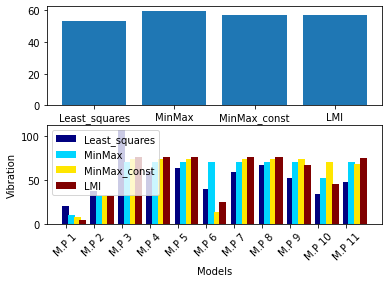

In [41]:
plot_models(models)